# 프로젝트: 한국어 데이터로 챗봇 만들기

### <목차>
#### Step 1. 데이터 수집하기
    (1) 중복데이터 확인
    (2) 중복데이터 제거
#### Step 2. 데이터 전처리하기
#### Step 3. SubwordTextEncoder 사용하기
    (1) 단어장 만들기
    (2) 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
    (3) 교사 강요(Teacher Forcing) 사용하기
#### Step 4. 모델 구성하기
    (1) 각종 함수 정의
        - 포지셔널 인코딩(Positional Encoding)
        - Scaled Dot Product Attention
        - 멀티-헤드 어텐션
        - Masking
        - 인코더
        - 디코더
        - 트랜스포머
    (2) 모델생성
    (3) 손실함수
    (4) 커스텀 된 학습률(Learning rate)
    (5) 모델 컴파일 및 훈련
#### Step 5. 모델 평가하기
#### 🤔회고🤔
#### 번외 : 실패목록들
    (1) 워드클라우드
    (2) 단어의 유사도
    (3) N-gram 통계
#### Reference

***

# Step 1. 데이터 수집하기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
dataset_korea = pd.read_csv(os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv')
print(dataset_korea.shape)
#dataset_korea.head()
dataset_korea

(11823, 3)


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


## (1) 중복 데이터 확인
- 대부분은 중복된 질문이 아니다.
- 2, 3, 4번씩 중복된 질문이 있으나 확인해보니 답변은 다르기 때문에 데이터 훈련을 위해 제거하지않고 남겨두었다.
- 2번째 실행은 중복된 질문을 삭제시켜주었다.

In [3]:
question = pd.Series(dataset_korea['Q'].to_list()).astype(str)

/tmp/ipykernel_2036/2350165645.py:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


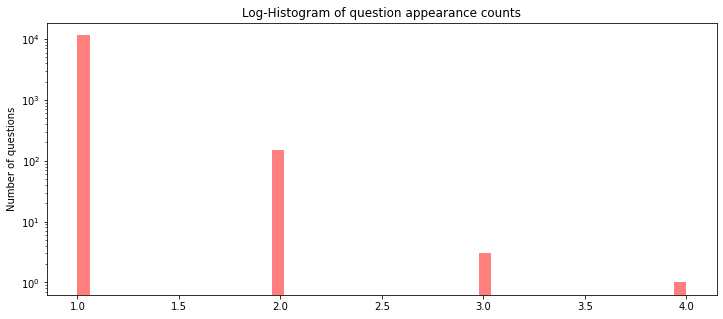

In [4]:
plt.figure(figsize=(12,5))
plt.hist(question.value_counts(), bins=50, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.ylabel('Number of questions')
plt.show()

In [5]:
print('교육 데이터의 총 질문 수 : {} 건'.format(len(np.unique(question))))

교육 데이터의 총 질문 수 : 11662 건


In [6]:
question.value_counts().describe()

count    11662.000000
mean         1.013806
std          0.121017
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
dtype: float64

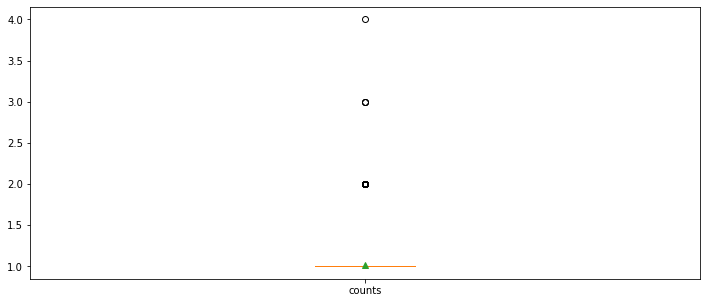

In [7]:
plt.figure(figsize=(12, 5))
plt.boxplot([question.value_counts()],
            labels=['counts'],
            showmeans=True)
plt.show()

## (2) 중복데이터 제거

In [8]:
dataset_korea.duplicated(['Q'])

0        False
1        False
2        False
3        False
4        False
         ...  
11818    False
11819     True
11820    False
11821    False
11822    False
Length: 11823, dtype: bool

In [9]:
dataset_korea = dataset_korea.drop_duplicates(['Q'])
dataset_korea

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11817,후회 없이 사랑하고 싶어,진심으로 다가가 보세요.,2
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


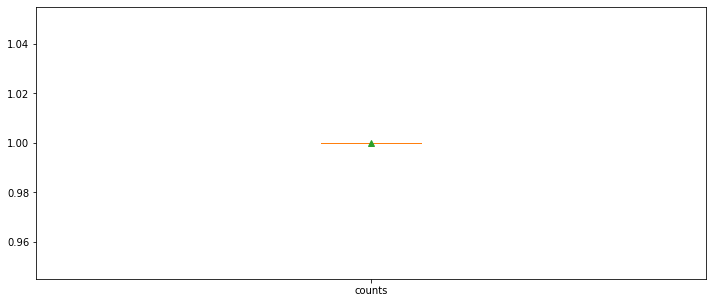

In [10]:
plt.figure(figsize=(12, 5))
plt.boxplot([dataset_korea.value_counts()],
            labels=['counts'],
            showmeans=True)
plt.show()

## Q와 A 가져오기 (찾아보기)
- 위에서 데이터를 살펴보니 이미 Q와 A로 나눠져있어서 따로 처리할 필요가 없는 것 같다.

In [17]:
# path_to_movie_lines = os.path.join(dataset_korea, 'movie_lines.txt')
# path_to_movie_conversations = os.path.join(dataset_korea,'movie_conversations.txt')

# Step 2. 데이터 전처리하기
- 우선 기존 영어 전처리를 그대로 사용한다.
- 단, a-z가 아닌 가-힣으로 설정해주어야 전처리가 오류없이 완료된다.

In [11]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (한글, 알파벳, 숫자 ".", "?", "!", ",")를 제외한 모든 문자를 공백으로 대체합니다.
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [12]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []
    for i in range(len(dataset_korea) - 1):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(dataset_korea['Q'].values[i]))
        outputs.append(preprocess_sentence(dataset_korea['A'].values[i]))
    return inputs, outputs
print("슝=3")

슝=3


In [13]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))
print('전처리 후의 1번째 질문 샘플: {}'.format(questions[1]))
print('전처리 후의 1번째 답변 샘플: {}'.format(answers[1]))

전체 샘플 수 : 11661
전체 샘플 수 : 11661
전처리 후의 1번째 질문 샘플: 1지망 학교 떨어졌어
전처리 후의 1번째 답변 샘플: 위로해 드립니다 .


# Step 3. SubwordTextEncoder 사용하기
## (1) 단어장 만들기

In [14]:
import tensorflow_datasets as tfds
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [15]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8097]
END_TOKEN의 번호 : [8098]


In [16]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8099


## (2) 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
- tokenizer.encode() : 각 단어를 정수로 변환
- tokenizer.decode() : 정수 시퀀스를 단어 시퀀스로 변환

In [17]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 1번째 질문 샘플: {}'.format(tokenizer.encode(questions[1])))
print('정수 인코딩 후의 1번째 답변 샘플: {}'.format(tokenizer.encode(answers[1])))

정수 인코딩 후의 1번째 질문 샘플: [7890, 47, 1022, 7873, 982, 1882]
정수 인코딩 후의 1번째 답변 샘플: [1812, 5457, 1]


In [18]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 30
print(MAX_LENGTH)

30


In [19]:
# 정수인코딩, 최대길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작, 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대 길이 30 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    # 최대 길이 30으로 모든 데이터셋 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post'
    )
    return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [20]:
# 중복데이터 제거

questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8099
필터링 후의 질문 샘플 개수: 11660
필터링 후의 답변 샘플 개수: 11660


In [59]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8163
필터링 후의 질문 샘플 개수: 11821
필터링 후의 답변 샘플 개수: 11821


## (3) 교사 강요(Teacher Forcing) 사용하기

In [21]:
# base model BATCH_SIZE = 64
BATCH_SIZE = 32
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


# Step 4. 모델 구성하기
## (1) 각종 함수 정의
## 포지셔널 인코딩(Positional Encoding)
- 트랜스포머는 문장의 단어들을 1개씩 순차적으로 받는 것이 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받음   
    => 이는 문장의 단어 순서를 구분 할 수 없는 문제를 해결하기 위해 사용한 기법

In [22]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
    # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


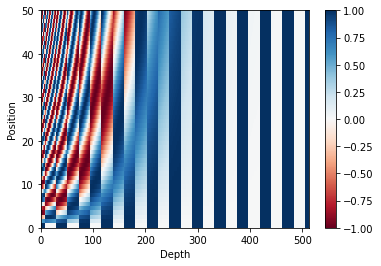

In [23]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Scaled Dot Product Attention
-  내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 QQ와 KK의 유사도를 구함

In [24]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

  # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

print("슝=3")

슝=3


## 멀티-헤드 어텐션
- 어텐션을 병렬로 수행하는 것
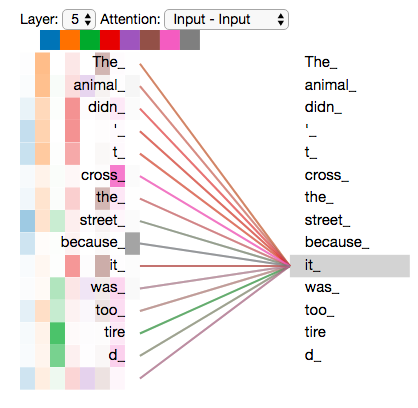

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs
print("슝=3")

슝=3


## Masking
- 패딩 토큰(Padding token)을 이용한 방법
- 케라스의 `pad_sequences()`를 사용하여 패딩을 하는 과정을 시각화한 그림
- 패딩을 통해 형성된 0은 의미 있는 데이터가 아니기 때문에 실제 어텐션 등과 같은 연산에서는 제외해야 함
    
    ⇒ 이를 위해 0의 위치를 체크하는 것을 패딩 마스킹이라 한다.

In [26]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [27]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

## 인코더
![인코더](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_22_teJgoCi.max-800x600.png)

In [28]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [29]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 디코더
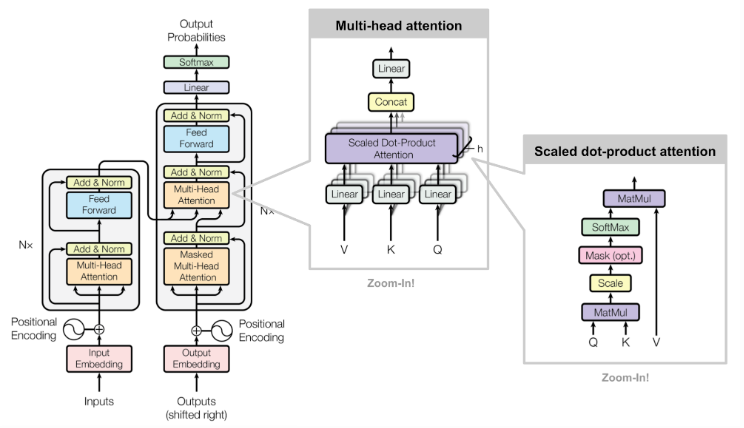

In [30]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [31]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 트랜스포머

In [32]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

  # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

  # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


## (2) 모델생성

In [33]:
# 중복 제거

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3127552     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [72]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3143936     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## (3) 손실함수

In [34]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


## (4) 커스텀 된 학습률(Learning rate)

In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

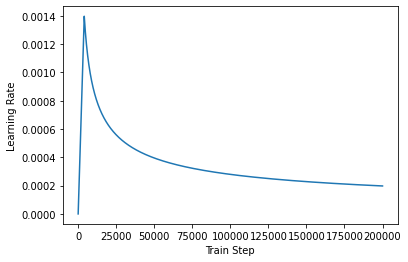

In [36]:
# 중복 제거

dataset_korea_learning_rate = CustomSchedule(d_model=128)

plt.plot(dataset_korea_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

Text(0.5, 0, 'Train Step')

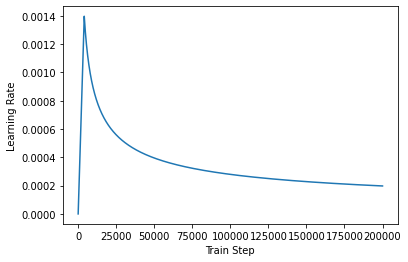

In [75]:
dataset_korea_learning_rate = CustomSchedule(d_model=128)

plt.plot(dataset_korea_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## (5) 모델 컴파일 및 훈련

In [37]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [38]:
# 훈련하기
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
365/365 [==============================] - 18s 32ms/step - loss: 1.7827 - accuracy: 0.0485
Epoch 2/50
365/365 [==============================] - 12s 32ms/step - loss: 1.3462 - accuracy: 0.0689
Epoch 3/50
365/365 [==============================] - 12s 32ms/step - loss: 1.2148 - accuracy: 0.0756
Epoch 4/50
365/365 [==============================] - 12s 32ms/step - loss: 1.1006 - accuracy: 0.0832
Epoch 5/50
365/365 [==============================] - 12s 32ms/step - loss: 0.9758 - accuracy: 0.0946
Epoch 6/50
365/365 [==============================] - 12s 32ms/step - loss: 0.8418 - accuracy: 0.1087
Epoch 7/50
365/365 [==============================] - 12s 32ms/step - loss: 0.7060 - accuracy: 0.1241
Epoch 8/50
365/365 [==============================] - 12s 32ms/step - loss: 0.5764 - accuracy: 0.1392
Epoch 9/50
365/365 [==============================] - 12s 32ms/step - loss: 0.4594 - accuracy: 0.1539
Epoch 10/50
365/365 [==============================] - 12s 32ms/step - loss: 0.360

- 그래프로 오버피팅 확인해보기

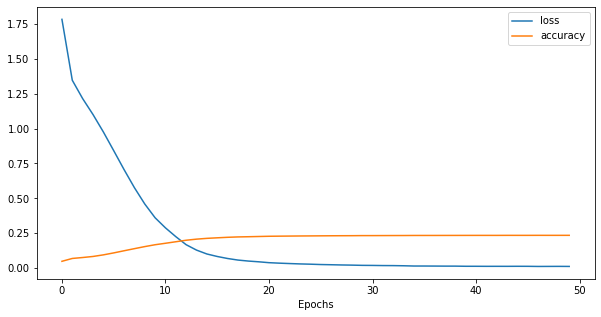

In [39]:
#hist.history
history_dict = history.history

import matplotlib.pyplot as plt

graph_loss = history_dict['loss']
graph_accuracy = history_dict['accuracy']

plt.figure(figsize=(10,5))
plt.plot(graph_loss, label='Sample loss')
plt.plot(graph_accuracy, label='Sample accuracy')
plt.xlabel('Epochs')
plt.legend(['loss', 'accuracy'])

# Step 5. 모델 평가하기
### <예측 단계>

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, `START_TOKEN`과 `END_TOKEN`을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. `END_TOKEN`이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.
7. 위의 과정을 모두 담은 `decoder_inference()` 함수를 만든다.

In [40]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [41]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


## ⭐최종⭐챗봇 대답 얻기

In [42]:
sentence_generation('심심해')
sentence_generation('저녁 뭐 먹을까?')
sentence_generation('비트코인 떨어졌어.')
sentence_generation('노래방 갈래?')
sentence_generation('지금 피곤해')
sentence_generation('나 너무 슬퍼')
sentence_generation('지금 졸려')
sentence_generation('나 살찐거 같아?')

입력 : 심심해
출력 : 노래 불러 드릴까요 ? 북치기박치기 헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥
입력 : 저녁 뭐 먹을까?
출력 : 맛있는 거 드세요 .
입력 : 비트코인 떨어졌어.
출력 : 안타깝지만 잊어버리세요 .
입력 : 노래방 갈래?
출력 : 저는 먼저 요 ?
입력 : 지금 피곤해
출력 : 주룩주룩 .
입력 : 나 너무 슬퍼
출력 : 후회 , 상상 , 자책 모두 멈출 때가 됐어요 .
입력 : 지금 졸려
출력 : 오늘 일찍 주무세요 .
입력 : 나 살찐거 같아?
출력 : 지금 연락해보세요 .


'지금 연락해보세요 .'

In [59]:
sentence_generation('심심해')
sentence_generation('저녁 뭐 먹을까?')
sentence_generation('비트코인 떨어졌어.')
sentence_generation('노래방 갈래?')
sentence_generation('지금 피곤해')
sentence_generation('나 너무 슬퍼')
sentence_generation('지금 졸려')
sentence_generation('나 살찐거 같아?')

입력 : 심심해
출력 : 노래 불러 드릴까요 ? 북치기박치기 헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥
입력 : 저녁 뭐 먹을까?
출력 : 냉장고 파먹기 해보세요 .
입력 : 비트코인 떨어졌어.
출력 : 안타깝지만 잊어버리세요 .
입력 : 노래방 갈래?
출력 : 즐거운 시간이 될 거 같아요
입력 : 지금 피곤해
출력 : 요즘 바쁜가봐요 .
입력 : 나 너무 슬퍼
출력 : 이제 같은 실수는 자신을 만나길 바랄게요 .
입력 : 지금 졸려
출력 : 오늘 일찍 주무세요 .
입력 : 나 살찐거 같아?
출력 : 잘 지내고 있을 거예요 .


'잘 지내고 있을 거예요 .'

## <노력의 흔적> 파라미터 수정
- 중복데이터는 loss 와 accuracy면에서 큰 차이는 없다.
- epoch 수를 늘릴 수록 loss값이 낮아진다.
- 그에 비해 accuracy는 큰 변화가 없다.
- BATCH_SIZE 128은 효과가 떨어지고, 32는 조금의 개선이 보인다.
- epoch 은 50정도가 적당한 것 같다. 그 이상은 오버피팅 현상을 보인다.
- accuracy가 상대적으로 높다고 챗봇의 대답이 정상적인건 아니다..

|구분|변경사항|loss|accuracy|
|---|---|---|---|
|A1|Base model, epoch=20|0.0625|0.2206|
|A2|중복 데이터 제거, epoch=20|0.0622|0.2219|
|A3|Base model, epoch=100|0.0023|0.2344|
|A4|Base model, epoch=20, BATCH_SIZE=128|0.3597|0.1736|
|A5|Base model, epoch=20, BATCH_SIZE=32|0.0446|0.2254|
|A6|Base model, epoch=100, BATCH_SIZE=32|0.0141|0.2335|
|A7|중복 데이터 제거, epoch=50, BATCH_SIZE=32|0.01181|0.2347|


## <노력의 흔적> 결과 분석
- 중복 데이터 제거는 일상 질문에서 기상천외한 답변을 내놓는다..ㅋㅋㅋ
- epoch 수가 높을 수록 자연스러운 답변이 나온다.
- BATCH_SIZE=128을 했더니 무슨 냉소적인 인간이 된 듯하다.
- BATCH_SIZE=32 했을 땐 진짜 ㅋㅋㅋㅋㅋ 첫 질문부터 빵 터졌다. 사실 첫 질문의 답변이 너무 센스 있어서 epoch 을 높이면 더욱 좋은 결과를 기대할 수 있을 것 같다.

|구분|Q|A1|A2|A3|A4|A5|A6|A7|
|---|---|---|---|---|---|---|---|---|
|1|심심해|저랑 놀아요 .|저랑 놀아요 .|친구들과 연락해보세요 .|친구들과 연락해보세요 .|노래 불러 드릴까요 ? 북치기박치기 헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥|친구들과 연락해보세요 .|노래 불러 드릴까요 ? 북치기박치기 헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥헥|
|2|저녁 뭐 먹을까?|맛있는 거 드세요 .|냉장고 파먹기 해보세요 .|맛있는 거 드세요 .|맛있는 거 드세요 .|냉장고 파먹기 해보세요 |냉장고 파먹기 해보세요 .|맛있는 거 드세요 .|
|3|비트코인 떨어졌어.|안타깝지만 잊어버리세요 .|안타깝지만 잊어버리세요 .|안타깝지만 잊어버리세요 .|잠시 쉬어도 괜찮아요 .|안타깝지만 잊어버리세요 .|안타깝지만 잊어버리세요 .|안타깝지만 잊어버리세요 .|
|4|노래방 갈래?|즐거운 시간이 될 거 같아요|누가 더 사랑하는지는 중요하지 않아요 .|그 더 많이 지나가길 바랄게요 .|될 거예요 .|즐거운 시간이 될 거 같아요|즐거운 시간이 될 거 같아요|저는 먼저 요 ?|
|5|지금 피곤해|좀 더 일찍 잠자리에 들어보세요 .|충전하는 시간 그 자체로 소중합니다 .|푹 쉬세요 .|시간 만큼 잘 이겨낼 수 있을 거예요 .|요즘 바쁜가봐요 .|요즘 바쁜가봐요 .|주룩주룩 .|
|6|나 너무 슬퍼|후회 , 상상 , 자책 모두 멈출 때가 됐어요 .|후회 , 상상 , 자책 모두 멈출 때가 됐어요 .|후회 , 상상 , 자책 모두 멈출 때가 됐어요 .|그런 날이 있더라고요 .|이제 같은 실수는 자신을 만나길 바랄게요 .|이제 같은 실수는 자신을 만나길 바랄게요 .|후회 , 상상 , 자책 모두 멈출 때가 됐어요 .|
|7|지금 졸려|잘 먹고 잘 자요 .|저도 모르겠어요 .|낮잠을 잠깐 자도 괜찮아요 .|오늘 일찍 주무세요 .|오늘 일찍 주무세요 .|오늘 일찍 주무세요 .|오늘 일찍 주무세요 .|
|8|나 살찐거 같아?|긴장감이 줄어서 그럴 수도 있어요 .|꿩 먹고 알 먹고네요 .|그 것도 사랑이예요 .|그런 날이 있더라고요 .|잘 지내고 있을 거예요 .|잘 지내고 있을 거예요 .|지금 연락해보세요 .|


# 🤔회고🤔
### <루브릭 평가 지표>
|   평가문항    |상세기준|
|---|---|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.|

### <이번 프로젝트에서 어려웠던 점>
1. 워드클라우드 한글 폰트 때문에 깨져서 보인다..   
    => 해결을 하고 싶어서 3시간 동안 붙잡고 있었는데, PC 폰트를 변경하여도 LOAD된 폴더를 끝끝내 찾지 못해 하지 못했다. 이부분이 상당히 어렵고 아쉬웠다.
2. NLP도 나름 여러 EDA가 있는데 어떤 알고리즘에는 어떤 EDA를 선정해야하는지가 아직까진 모호해보였다. 이는 반복 훈련을 통해 선정하는 눈을 길러야 할 듯하다.

### <프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점>
1. NLP의 EDA 과정들
- 아래 참고 링크들을 Reference에 달아두었다.

2. 단어의 유사도
- 자카드 유사도( Jaccard Similarity)
    - 두 문장을 각각 단어의 집합으로 만든 뒤 두 집합을 통해 유사도를 측정하는 방식 중 하나

    - 유사도를 측정하는 방법은 두 집합의 교집합인 공통된 단어의 개수를 두 집합의 합집합, 전체 단어의 갯수로 나눈다.

    - 결괏값은 공통의 원소의 개수에 따라 0과 1사이의 값이 나올 것이고, 1에 가까울수록 유사도가 높다
    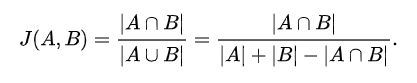
- 코사인 유사도
    - 코사인 유사도는 두 개의 벡터값에서 코사인 각도를 구하는 방법이다. 

    - 코사인 유사도 값은 -1과 1사이의 값을 가지고 1에 가까울수록 유사하다는 것을 의미한다.

    - 유사도를 계산할 때 가장 널리 쓰이는 방법 중 하나다. 일반적으로 성능이 좋기 때문!

    - 단순히 좌표 상의 거리를 구하는 다른 유사도 측정과 달리 두 벡터의 각도를 구하므로 방향성의 개념이 더해진다.

    - 두 문장이 유사하다면 같은 방향을 가리키고, 그렇지 않다면 직교로 표현 될 것이다.
    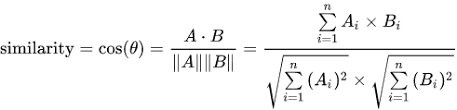
    
- 유클리디언 유사도 ( L2 Distance )
    - 가장 기본적인 거리를 측정하는 유사도 공식이다.
    - 유클리디언 거리 = L2 거리 : N차원 공간에서 두 점 사이의 최단 거리를 구하는 접근법
    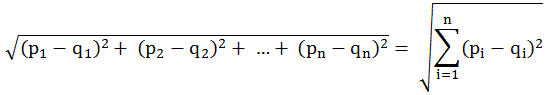


3. N-gram
-  Bag of Words , TF-IDF 와 같이 횟수를 사용하여 단어를 벡터로 표현(Count-based representation) 하는 방법
-  n개의 연속적인 단어 나열을 의미
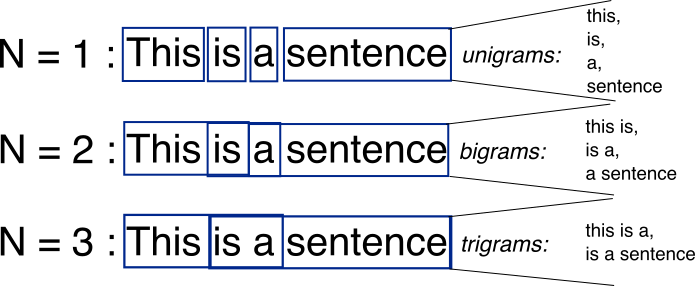

### <루브릭 평가 지표를 맞추기 위해 시도한 것들>
1. 중복된 데이터가 있으면 제거해주고자 하였다.
    - 질문 샘플 개수 변화: 11660 => 11821
2. 이상치가 있으면 제거하고자 하였다.
3. 가장 많이 사용된 단어를 통해 실험해보고자 하였다.
4. 단어의 유사도 및 N-gram을 통해 정보를 확인하고자 하였지만 실패하였다 ㅠㅠ
챗봇 친절한 듯한데 팩폭을 너무 잘 떄린다...!
5. epoch를 수정하였다.
6. BATCH_SIZE를 수정하였다.

### <만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정>
없음

### <자기 다짐>
 공부해야 할 내용도 많고 배워야 할 내용도 많다.    
 확실히 CV에 비하면 양이 방대한 것 같지만 차근차근 공부하는 걸로..
 데이터 증강을 통해서 모델의 효과를 높일 수 있을 것 같지만 이번은 시간이 부족해 진행하지 못했다.   
 이 부분은 따로 해보는 것도 좋을 것 같다.


# 번외 : 실패목록들
## (1) 워드클라우드

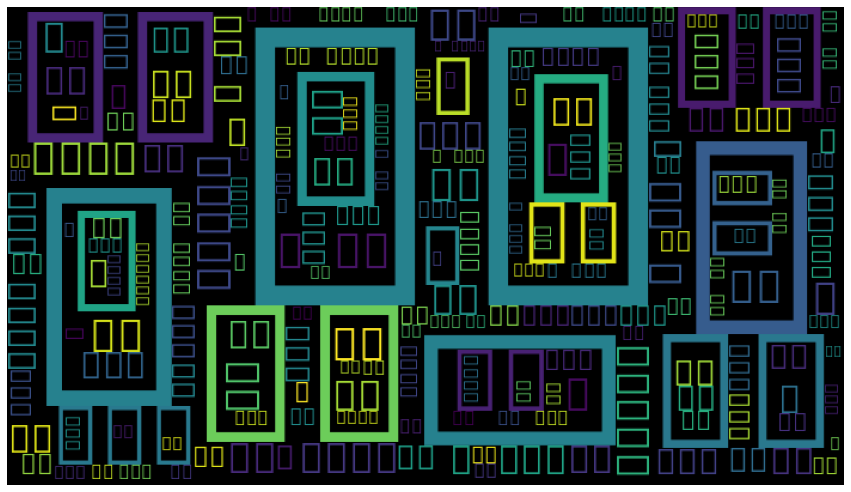

In [46]:
from wordcloud import WordCloud
cloud = WordCloud(width=700, height=400).generate(' '.join(question.astype(str)))
#gen = cloud.generate_from_frequencies()
plt.figure(figsize=(15,13))
plt.imshow(cloud)
plt.axis('off')
plt.show()

## (2) 단어의 유사도
- TF-IDF를 통한 벡터화

In [19]:
question = dataset_korea['Q']
answer = dataset_korea['A']

answer

0                      하루가 또 가네요.
1                       위로해 드립니다.
2                     여행은 언제나 좋죠.
3                     여행은 언제나 좋죠.
4                      눈살이 찌푸려지죠.
                   ...           
11818          티가 나니까 눈치가 보이는 거죠!
11819               훔쳐보는 거 티나나봐요.
11820                      설렜겠어요.
11821    잘 헤어질 수 있는 사이 여부인 거 같아요.
11822          도피성 결혼은 하지 않길 바라요.
Name: A, Length: 11823, dtype: object

In [14]:

from sklearn.feature_extraction.text import TfidfVectorizer

# 객체 생성
question_vectorizer = TfidfVectorizer()
answer_vectorizer = TfidfVectorizer()


# 문장 벡터화 진행
question_matrix = question_vectorizer.fit_transform(question)
answer_matrix = answer_vectorizer.fit_transform(answer)


# 각 단어
text_q = question_vectorizer.get_feature_names()
text_a = answer_vectorizer.get_feature_names()

# 각 단어의 벡터 값
#idf = tfidf_vectorizer.idf_

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(question[1:2], question[2:3])

ValueError: could not convert string to float: '1지망 학교 떨어졌어'

## (3) N-gram 통계

In [9]:
from nltk import ngrams
from nltk import bigrams

In [11]:
question =dataset_korea['Q'].to_list()

from sklearn.feature_extraction.text import CountVectorizer

m_corpus = []
for t in question:
	m_corpus.append(' '.join(m.morphs(t)))

def get_top_ngram(corpus, n=None):
	vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
	bag_of_words = vec.transform(corpus)
	sum_words = bag_of_words.sum(axis=0)
	words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
	words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
	return words_freq[:20]

NameError: name 'm' is not defined

# Reference
1. 한글 폰트 설정 : https://koosco.tistory.com/38
2. 한글 워드 클라우드 : https://doitgrow.com/34
3. NLP 텍스트 유사도1 : https://heung-bae-lee.github.io/2020/02/10/NLP_10/
4. NLP 텍스트 유사도2 : https://soyoung-new-challenge.tistory.com/34
5. 자연어 EDA : https://skyjwoo.tistory.com/entry/%EC%9E%90%EC%97%B0%EC%96%B4-%EC%B2%98%EB%A6%AC-EDAExploratory-Data-Analysis